# KTP OCR Project
Oleh Teguh Rijanandi teguhrijanandi02@gmail.com

## Install Library yang dibutuhkan

In [11]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract
!pip install opencv-python
!pip install imutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Clone tessdata tesseract-ocr

In [12]:
!git clone https://github.com/tesseract-ocr/tessdata

fatal: destination path 'tessdata' already exists and is not an empty directory.


## Clone haarcascade_frontalface_default.xml

In [13]:
!wget https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/haarcascade_frontalface_default.xml

--2024-03-01 07:07:49--  https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254733 (1.2M) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>]   1.20M  --.-KB/s    in 0.05s   

2024-03-01 07:07:49 (22.7 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [1254733/1254733]



## Download contoh KTP

In [14]:
!wget https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/ktp_contoh/ktp_contoh.jpg

--2024-03-01 07:07:49--  https://raw.githubusercontent.com/teguh02/KTP-OCR-Python-Projects/main/ktp_contoh/ktp_contoh.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131257 (128K) [image/jpeg]
Saving to: ‘ktp_contoh.jpg.1’

ktp_contoh.jpg.1    100%[===================>] 128.18K  --.-KB/s    in 0.02s   

2024-03-01 07:07:49 (5.89 MB/s) - ‘ktp_contoh.jpg.1’ saved [131257/131257]



# Definisi Fungsi dan Library

## Import library python

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

## Fungsi untuk memeriksa kualitas gambar

In [16]:
def check_image_quality(image_path):
    # 1. Cek apakah file tidak kosong
    if not image_path:
        return {
            'status': False,
            'error': "File tidak boleh kosong."
        }

    # 2. Cek apakah file merupakan file gambar
    try:
        image = cv2.imread(image_path)
        if image is None:
            return {
                'status': False,
                'error': "File bukan gambar atau tidak dapat dibaca."
            }
    except Exception as e:
        return {
            'status': False,
            'error': "Terjadi kesalahan saat membaca file: {}".format(str(e))
        }

    # 3. Cek resolusi gambar
    height, width, _ = image.shape
    min_resolution = (800, 600)  # Atur sesuai dengan kebutuhan
    if height < min_resolution[1] or width < min_resolution[0]:
        return {
            'status': False,
            'error': "Resolusi gambar terlalu kecil. Harap gunakan gambar dengan resolusi minimal {}x{}.".format(min_resolution[0], min_resolution[1])
        }

    # 4. Cek tingkat keburaman gambar
    blur_threshold = 100  # Atur sesuai dengan kebutuhan
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_score = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    if blur_score < blur_threshold:
        return {
            'status': False,
            'error': "Gambar terlalu buram. Harap gunakan gambar yang lebih jelas."
        }

    # Jika semua pengecekan berhasil, kembalikan status True tanpa error
    return {
        'status': True,
        'error': None
    }

## Fungsi untuk pendeteksian wajah pada KTP

In [17]:
def detect_and_outline(image):
    # Implementasi deteksi dan penjajaran
    # Misalnya, menggunakan algoritma deteksi wajah Haar cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    # Gambar kotak persegi panjang di sekitar setiap wajah
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Kembalikan gambar hasil deteksi dan objek yang telah di-outline
    return image, faces

## Fungsi untuk menghilangkan gambar wajah menjadi hitam

In [18]:
def remove_faces(image, faces):
    # Cek apakah image adalah numpy array
    if isinstance(image, np.ndarray):
        # Jika ya, buat salinan gambar asli
        image_copy = np.copy(image)
    else:
        # Jika tidak, gunakan image copy
        image_copy = image.copy()

    # Ganti area wajah dengan warna hitam
    for (x, y, w, h) in faces:
        image_copy[y:y+h, x:x+w] = (0, 0, 0)  # (0, 0, 0) merupakan warna hitam dalam ruang warna BGR

    return image_copy

## Fungsi untuk ekstraksi teks

In [19]:
def text_detection(image):
    # Cek apakah image adalah numpy array
    if isinstance(image, np.ndarray):
        # Jika ya, buat salinan gambar asli
        image_copy = np.copy(image)
    else:
        # Jika tidak, gunakan image copy
        image_copy = image.copy()

    # Atur konfigurasi bahasa menjadi bahasa Indonesia dan tambahkan kamus bahasa Indonesia
    custom_config = r'--oem 3 --psm 6 -l ind --tessdata-dir "/content/tessdata"'
    # Lakukan deteksi teks dengan Tesseract OCR
    detected_text_result = pytesseract.image_to_string(image_copy, config=custom_config)
    # Bagi teks menjadi baris-baris
    detected_text_lines = detected_text_result.split('\n')
    # Hapus baris kosong
    detected_text_lines = [line.strip() for line in detected_text_lines if line.strip()]
    return detected_text_lines

## Fungsi untuk klasifikasi teks dalam KTP

In [20]:
def classify_text(recognized_text):
    # Klasifikasikan teks untuk mengekstraksi informasi yang diinginkan
    extracted_information = {
        'Nama': '',
        'Tempat/Tgl Lahir': '',
        'Jenis Kelamin': '',
        'Alamat': {'RT/RW': '', 'Kel/Desa': '', 'Kecamatan': ''},
        'Agama': '',
        'Status Perkawinan': '',
        'Pekerjaan': '',
        'Kewarganegaraan': '',
        'Berlaku Hingga': ''
    }

    # Loop melalui setiap baris teks untuk mengekstraksi informasi yang relevan
    for line in recognized_text:
        if 'Nama :' in line:
            extracted_information['Nama'] = line.split(':')[-1].strip()
        elif 'Tempat/TgiLahir :' in line:
            tempat_tgl_lahir = line.split(':')[-1].strip()
            tempat_tgl_list = tempat_tgl_lahir.split(',')
            if len(tempat_tgl_list) >= 2:
                tempat_lahir, tgl_lahir = tempat_tgl_list[0].strip(), tempat_tgl_list[1].strip()
                extracted_information['Tempat/Tgl Lahir'] = tempat_lahir + ', ' + tgl_lahir
        elif 'Jenis kelamin' in line:
            jenis_kelamin_list = line.split('-')
            if len(jenis_kelamin_list) >= 2:
                extracted_information['Jenis Kelamin'] = jenis_kelamin_list[-1].strip()
        elif 'Alamat -' in line:
            alamat_list = line.split('-')
            if len(alamat_list) >= 2:
                alamat = alamat_list[-1].strip().split(',')
                if len(alamat) >= 3:
                    extracted_information['Alamat']['RT/RW'] = alamat[0].strip()
                    extracted_information['Alamat']['Kel/Desa'] = alamat[1].strip()
                    extracted_information['Alamat']['Kecamatan'] = alamat[2].strip()
        elif 'Agama :' in line:
            extracted_information['Agama'] = line.split(':')[-1].strip()
        elif 'Status Perkawinan:' in line:
            extracted_information['Status Perkawinan'] = line.split(':')[-1].strip()
        elif 'Pekerjaan :' in line:
            extracted_information['Pekerjaan'] = line.split(':')[-1].strip()
        elif 'Kewarganegaraan:' in line:
            extracted_information['Kewarganegaraan'] = line.split(':')[-1].strip()
        elif 'Berlaku Hingga' in line:
            extracted_information['Berlaku Hingga'] = line.split(':')[-1].strip()

    return extracted_information

# Proses Ekstraksi

## Definisi ekstraksi

In [21]:
filepath = 'ktp_contoh.jpg'
check_image = check_image_quality(filepath)

if check_image['status'] == True:
  image = cv2.imread(filepath)
else:
  print(check_image['error'])

## Deteksi wajah

In [22]:
detected, outlined = detect_and_outline(image)

## Hilangkan wajah

In [23]:
remove_faces = remove_faces(detected, outlined)

## Pendeteksian Teks

In [24]:
text_detection = text_detection(remove_faces)
print(text_detection)

['PROVINSI DKI JAKARTA', 'JAKARTA TIMUR', 'NIK : 3175070101909999', 'Nama : BILLY BUMBLEBEE SIFULAN', 'Tempat/Tgl Lahir : SURABAYA, 01-01-1990', 'Jenis Kelamin : LAKI-LAKI Gol. Darah : AB', 'Alamat : JL DIMANA NO 100', 'RT/RW : 001/001', 'Kel/Desa : ANTAH BERANTAH x y', 'Kecamatan : DUREN SAWIT', 'Agama : ISLAM', 'Status Perkawinan : KAWIN', 'Pekerjaan : KARYAWAN SWASTA', 'Kewarganegaraan : WNI $ A ABTA RIOR', 'Berlaku Hingga — : SEUMUR HIDUP 01012020']


## Klasifikasi teks KTP

In [25]:
classify_text = classify_text(text_detection)
print(classify_text)

{'Nama': 'BILLY BUMBLEBEE SIFULAN', 'Tempat/Tgl Lahir': '', 'Jenis Kelamin': '', 'Alamat': {'RT/RW': '', 'Kel/Desa': '', 'Kecamatan': ''}, 'Agama': 'ISLAM', 'Status Perkawinan': '', 'Pekerjaan': 'KARYAWAN SWASTA', 'Kewarganegaraan': '', 'Berlaku Hingga': 'SEUMUR HIDUP 01012020'}


## Tampilkan hasil KTP

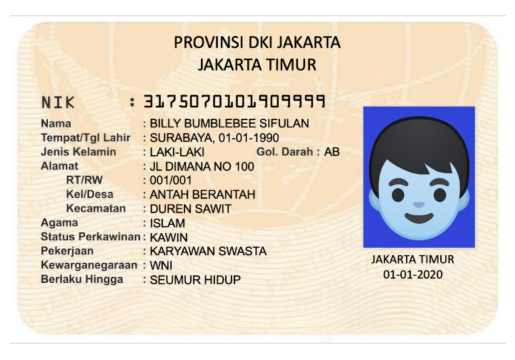

In [26]:
# Tampilkan gambar hasil penghilangan wajah
plt.imshow(remove_faces)
plt.axis('off')
plt.show()